In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cryptovision.dataset as dataset
from loguru import logger

2025-02-16 14:14:24.859 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
df = dataset.main(min_samples=90, verbose=True)

# Drop columns that are not needed ['duplicates', 'flag_small']
df = df.drop(columns=['duplicates', 'flag_small'])
print(" ")
logger.info(f"DataSet Dimentions: {df.shape[0]} samples, {df.shape[1]} features")
logger.info(f"Taxonomy Numbers: Fam: {len(df.family.unique())}, Gen: {len(df.genus.unique())}, Sp: {len(df.species.unique())}")
logger.info(f"Minimum of Samples per Species: {df.groupby('species').size().min()}")
logger.info(f"Maximum of Samples per Species: {df.groupby('species').size().max()}")

2025-02-16 14:14:25.639 | INFO     | cryptovision.dataset:main:46 - DataSet sjb loaded -> Size: (7493, 20)
2025-02-16 14:14:25.653 | INFO     | cryptovision.dataset:main:46 - DataSet scls loaded -> Size: (358, 20)
2025-02-16 14:14:25.657 | INFO     | cryptovision.dataset:main:46 - DataSet lirs loaded -> Size: (877, 20)
2025-02-16 14:14:25.660 | INFO     | cryptovision.dataset:main:46 - DataSet cbc loaded -> Size: (362, 20)
2025-02-16 14:14:25.680 | INFO     | cryptovision.dataset:main:46 - DataSet web loaded -> Size: (6421, 20)
2025-02-16 14:14:25.720 | INFO     | cryptovision.dataset:main:46 - DataSet inat loaded -> Size: (14405, 20)
2025-02-16 14:14:25.722 | INFO     | cryptovision.dataset:main:52 - Initial DataSet Size: 29,916
2025-02-16 14:14:25.726 | INFO     | cryptovision.dataset:main:53 - Fam 28 | Gen 81 | Spec 190
2025-02-16 14:14:25.735 | INFO     | cryptovision.dataset:main:57 - Number of duplicates: 0
2025-02-16 14:14:25.740 | INFO     | cryptovision.dataset:main:62 - Filtr

In [3]:
non_clean_species = [
    'Labridae_Thalassoma_lunare', 
    'Monacanthidae_Monacanthus_tuckeri', 
    'Pinguipedidae_Parapercis_cylindrica', 
    'Pomacanthidae_Centropyge_bispinosa', 
    'Pomacanthidae_Centropyge_flavissima', 
    'Pomacanthidae_Pomacanthus_maculosus', 
    'Pomacentridae_Chromis_atripectoralis', 
    'Pomacentridae_Chromis_iomelas', 
    'Pomacentridae_Chromis_lepidolepis', 
    'Pomacentridae_Chromis_margaritifer', 
    'Pomacentridae_Chrysiptera_rollandi', 
    'Pomacentridae_Dascyllus_aruanus', 
    'Pomacentridae_Dascyllus_reticulatus', 
    'Pomacentridae_Neopomacentrus_azysron', 
    'Pomacentridae_Neopomacentrus_cyanomos', 
    'Pomacentridae_Pomacentrus_adelus', 
    'Pomacentridae_Pomacentrus_amboinensis', 
    'Pomacentridae_Pomacentrus_bankanensis', 
    'Pomacentridae_Pomacentrus_brachialis', 
    'Pomacentridae_Pomacentrus_chrysurus', 
    'Pomacentridae_Pomacentrus_lepidogenys', 
    'Pomacentridae_Pomacentrus_moluccensis', 
    'Pomacentridae_Pomacentrus_nagasakiensis', 
    'Pomacentridae_Pomacentrus_pavo', 
    'Pomacentridae_Pomacentrus_wardi', 
    'Pseudochromidae_Cypho_purpurascens', 
    'Pseudochromidae_Pseudochromis_fuscus', 
    'Sciaenidae_Eques_punctatus', 
    'Scorpaenidae_Caracanthus_maculatus', 
    'Scorpaenidae_Scorpaenodes_parvipinnis', 
    'Serranidae_Cephalopholis_cyanostigma', 
    'Syngnathidae_Corythoichthys_conspicillatus', 
    'Syngnathidae_Corythoichthys_flavofasciatus', 
    'Syngnathidae_Doryrhamphus_excisus', 
    'Tetraodontidae_Canthigaster_solandri',
]

logger.info(f'Number of non-cleaned species: {len(set(non_clean_species))}')

def was_clean(sp, sp_list):
    if sp in sp_list:
        return False
    else:
        return True

# Create cleaned column
df['clean'] = df['folder_label'].apply(lambda x: was_clean(x, non_clean_species))

if len(non_clean_species) == df[~df['clean']]['species'].nunique():
    logger.success('All non-clean species were correctly identified')
else:
    logger.error('Some non-clean species were not correctly identified')

2025-02-16 14:14:25.767 | INFO     | __main__:<module>:39 - Number of non-cleaned species: 35
2025-02-16 14:14:25.778 | SUCCESS  | __main__:<module>:51 - All non-clean species were correctly identified


### Chart - Source Percentage of Total Data

In [4]:
import plotly.express as px

plot_data = df['source'].value_counts().reset_index()

fig = px.pie(plot_data, values='count', names='source', title=f'Source Distribution - Total: {df.shape[0]:,}')
fig.show()

### Create Train, Validation and Test Sets (Pandas & Tensorflow)

In [91]:
import cryptovision.tools as tools

train_df, val_df, test_df = tools.split_dataframe(
    df,
    test_size=0.15,
    val_size=0.15,
)

test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=(299, 299),
    shuffle=False
)

test_df.reset_index(drop=True, inplace=True)

logger.info(f"Train size: {len(train_df)} ({len(train_df) / len(df) * 100:.2f}%)")
logger.info(f"Validation size: {len(val_df)} ({len(val_df) / len(df) * 100:.2f}%)")
logger.info(f"Test size: {len(test_df)} ({len(test_df) / len(df) * 100:.2f}%)")

2025-02-16 14:18:41.922 | INFO     | __main__:<module>:18 - Train size: 19628 (70.00%)
2025-02-16 14:18:41.923 | INFO     | __main__:<module>:19 - Validation size: 4206 (15.00%)
2025-02-16 14:18:41.923 | INFO     | __main__:<module>:20 - Test size: 4206 (15.00%)


### CryptoVision AI Initialization

In [6]:
from cryptovision.tools import CryptoVisionAI

labels = {
    'family': sorted(df['family'].unique().tolist()),
    'genus': sorted(df['genus'].unique().tolist()),
    'species': sorted(df['species'].unique().tolist()),
}

ai = CryptoVisionAI(
    model_path = '/Users/leonardo/Documents/Projects/cryptovision/models/DataSetClean_M_v7/model_fine_tuned.keras',
    family_names= labels['family'],
    genus_names= labels['genus'],
    species_names= labels['species'],
)


### Sample Test Data Prediction

2025-02-16 14:17:46.427 | SUCCESS  | __main__:<module>:4 - True Label: Fam Gobiidae | Gen: Pleurosicya | Spec: Pleurosicya labiata - ID: 799
2025-02-16 14:17:46.585 | SUCCESS  | __main__:<module>:9 - Pred Clean: Fam Gobiidae | Gen: Pleurosicya | Spec: Pleurosicya labiata - Confidence: (0.8867, 0.656, 0.443)


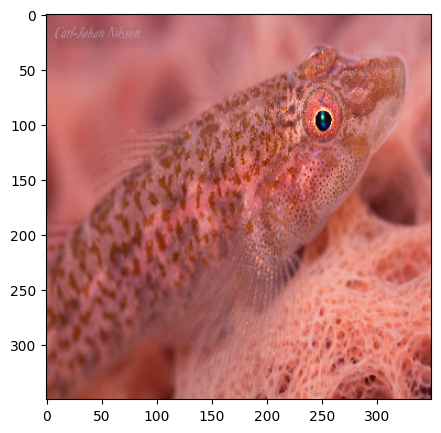

In [87]:
sample = test_df.sample(1)

for row, data in sample.iterrows():
    logger.success(f"True Label: Fam {data['family']} | Gen: {data['genus']} | Spec: {data['species']} - ID: {row}")
    
    preds = ai.predict(data['image_path'])
    
    if preds[0] == data['family'] and preds[1] == data['genus'] and preds[2] == data['species']:
        logger.success(f"Pred Clean: Fam {preds[0]} | Gen: {preds[1]} | Spec: {preds[2]} - Confidence: {ai.confidence}")
    else:
        logger.error(f"Pred Clean: Fam {preds[0]} | Gen: {preds[1]} | Spec: {preds[2]} - Confidence: {ai.confidence}")
  
plt.figure(figsize=(5, 5))  
plt.imshow(ai.image)
plt.show()

### Predict Test Set

In [92]:
predictions = ai.predict(test_ds)

2025-02-16 14:18:44.534034: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: Exception encountered when calling RandomCrop.call().

[1mfloat() argument must be a string or a real number, not 'SymbolicTensor'[0m

Arguments received by RandomCrop.call():
  • inputs=tf.Tensor(shape=(None, None, None, 3), dtype=float16)
  • training=False

In [66]:
data = {
    'family_pred': [],
    'family_conf': [],
    'genus_pred': [],
    'genus_conf': [],
    'species_pred': [],
    'species_conf': []
}

for pred in predictions:
    
    data['family_pred'].append(pred['family']['label'])
    data['family_conf'].append(pred['family']['confidence'])
    
    data['genus_pred'].append(pred['genus']['label'])
    data['genus_conf'].append(pred['genus']['confidence'])
    
    data['species_pred'].append(pred['species']['label'])
    data['species_conf'].append(pred['species']['confidence'])
    
    
test_df = pd.concat([test_df, pd.DataFrame(data)], axis=1)

In [67]:
test_df.head(10)

image_path  \
0  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
1  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
2  /Volumes/T7_shield/CryptoVision/Data/Sources/W...   
3  /Volumes/T7_shield/CryptoVision/Data/Sources/L...   
4  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
5  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
6  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
7  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
8  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
9  /Volumes/T7_shield/CryptoVision/Data/Sources/W...   

                            folder_label         family          genus  \
0          Gobiidae_Fusigobius_neophytus       Gobiidae     Fusigobius   
1       Pomacentridae_Pomacentrus_adelus  Pomacentridae    Pomacentrus   
2      Cirrhitidae_Paracirrhites_arcatus    Cirrhitidae  Paracirrhites   
3         Gobiidae_Paragobiodon_modestus       Gobiidae   Paragobiodon   
4      Syngnathidae_Doryrhamphus_excisus   Syngnathidae   Doryrhamphus   
5  Blenniidae_Plagiotremus_rhinorhynchus     Blenniidae   Plagiotremus   
6     Pomacentridae_Chromis_margaritifer  Pomacentridae        Chromis   
7      Labridae_Thalassoma_amblycephalum       Labridae     Thalassoma   
8      Apogonidae_Pristiapogon_exostigma     Apogonidae   Pristiapogon   
9            Gobiidae_Eviota_atriventris       Gobiidae         Eviota   

                      species source              hash  width  height  \
0        Fusigobius neophytus   inat  c183f04187bc9bfc   1505    1129   
1          Pomacentrus adelus   inat  bae6cd383245ae4a   1350    1352   
2       Paracirrhites arcatus    web  d53b6a0a3527d8b4    370     276   
3       Paragobiodon modestus    sjb  c11e9e63e01e0ff1   4288    2848   
4        Doryrhamphus excisus   inat  a5a2d16d9d4d3c4c   1068     602   
5  Plagiotremus rhinorhynchus   inat  d1180a2f3d75f263    700     701   
6        Chromis margaritifer   inat  d481bac769362eaa   1071    1292   
7    Thalassoma amblycephalum   inat  9a95aa56edb469c0   1400    1402   
8      Pristiapogon exostigma   inat  da156d6a973043ce    650     651   
9          Eviota atriventris    web  f34ad1f60cc9b234    370     276   

   aspect_ratio  ...  entropy blur_score   dominant_color  clean  \
0          1.33  ...  8.49259     124.82   (106, 106, 87)   True   
1          1.00  ...  8.92981     281.40   (102, 110, 89)  False   
2          1.34  ...  8.98470     452.06   (173, 117, 80)   True   
3          1.51  ...  7.30141       4.94     (30, 32, 34)   True   
4          1.77  ...  8.68835      79.24     (67, 55, 49)  False   
5          1.00  ...  9.28405     320.47  (106, 105, 127)   True   
6          0.83  ...  8.93327     107.01  (109, 149, 139)  False   
7          1.00  ...  6.82042       8.40     (34, 54, 71)   True   
8          1.00  ...  8.42698     238.91     (69, 71, 81)   True   
9          1.34  ...  9.19798    1089.29    (136, 90, 81)   True   

     family_pred  family_conf     genus_pred genus_conf  \
0       Gobiidae     0.908203     Fusigobius   0.599609   
1  Pomacentridae     0.919922    Pomacentrus   0.791992   
2     Blenniidae     0.360352  Paracirrhites   0.645996   
3       Gobiidae     0.966309   Paragobiodon   0.959961   
4       Labridae     0.324707   Pristiapogon   0.341309   
5  Pomacanthidae     0.248657   Plagiotremus   0.981445   
6  Pomacentridae     0.734863        Chromis   0.475098   
7       Labridae     0.958496     Thalassoma   0.933594   
8     Apogonidae     0.844727   Pristiapogon   0.753418   
9       Gobiidae     0.974609         Eviota   0.855469   

                 species_pred species_conf  
0      Fusigobius signipinnis     0.301758  
1          Pomacentrus adelus     0.769043  
2       Paracirrhites arcatus     0.600586  
3       Paragobiodon modestus     0.978027  
4      Pristiapogon exostigma     0.408447  
5  Plagiotremus rhinorhynchus     0.867188  
6        Chromis margaritifer     0.327637  
7    Thalassoma amblycephalum     0.965820  
8 

### Analyze the effect of data cleaning on the model's performance

In [70]:
from sklearn.metrics import accuracy_score, confusion_matrix

taxon = 'genus'

acc = accuracy_score(test_df[taxon], test_df[f'{taxon}_pred'])

print(f"Accuracy {taxon}: {acc * 100:.2f}%")

test_df['correct'] = test_df[taxon] == test_df[f'{taxon}_pred']

# Identify the misclassifications
mistakes = test_df[~test_df['correct']]

# Group the mistakes by (true, predicted) pair and count them
mistakes_summary = mistakes.groupby([taxon, f'{taxon}_pred']).size().reset_index(name='count')
mistakes_summary = mistakes_summary.sort_values(by='count', ascending=False)
print("\nMost common mistakes:")
print(mistakes_summary.head(10))

Accuracy genus: 87.30%

Most common mistakes:
              genus   genus_pred  count
50          Chromis  Pomacentrus     31
56      Chrysiptera  Pomacentrus     14
208  Neopomacentrus  Pomacentrus     14
240     Pomacentrus      Chromis     13
121  Enneapterygius         Ucla     12
177      Istigobius   Fusigobius     11
262   Pseudochromis  Pomacentrus     11
26       Centropyge  Pomacentrus      8
238     Pomacentrus   Centropyge      7
98        Dascyllus  Pomacentrus      5


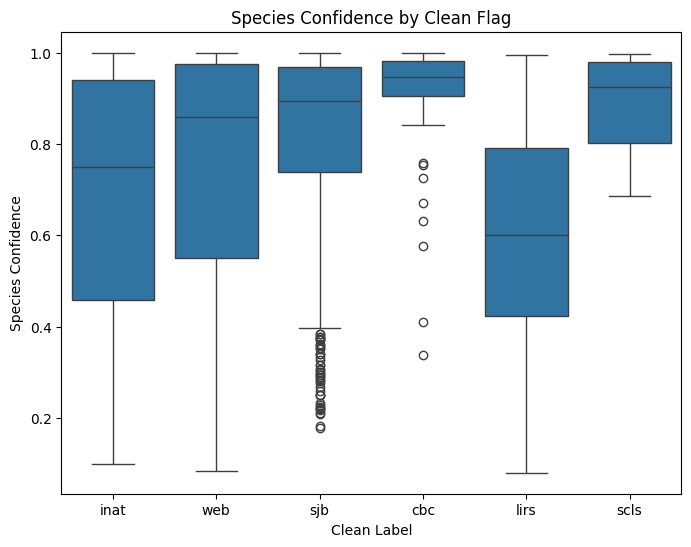

In [72]:
import seaborn as sns

# a. Visualize distribution of confidence for clean vs. non-clean samples.
plt.figure(figsize=(8, 6))
sns.boxplot(x='source', y='species_conf', data=test_df)
plt.title('Species Confidence by Clean Flag')
plt.xlabel('Clean Label')
plt.ylabel('Species Confidence')
plt.show()

In [20]:
# b. Compare the average confidence between clean and not-clean samples.
mean_conf_by_clean = test_df.groupby('clean')['species_conf'].mean()
print("Mean Species Confidence by Clean Flag:")
print(mean_conf_by_clean)

Mean Species Confidence by Clean Flag:
clean
False    0.621353
True     0.716528
Name: species_conf, dtype: float64


In [21]:
from scipy import stats

# c. Perform a statistical test (Point-Biserial Correlation)
#    since 'clean' is binary (True/False) and species_conf is continuous.
#    Convert the boolean flag to integer (True=1, False=0).
r, p_value = stats.pointbiserialr(test_df['clean'].astype(int), test_df['species_conf'])
print(f"\nPoint-Biserial Correlation: r = {r:.3f}, p-value = {p_value:.3f}")


Point-Biserial Correlation: r = 0.170, p-value = 0.000


In [22]:
test_df['correct'] = test_df['species'] == test_df['species_pred']

accuracy_by_clean = test_df.groupby('clean')['correct'].mean()
print("Accuracy by Clean Flag:")
print(accuracy_by_clean)

Accuracy by Clean Flag:
clean
False    0.705066
True     0.829656
Name: correct, dtype: float64


In [57]:
# Average confidence by clean flag and prediction correctness
avg_confidence = test_df.groupby(['clean', 'correct'])['species_conf'].mean().reset_index()
print("\nAverage Confidence by Clean Flag and Correctness:")
print(avg_confidence)


Average Confidence by Clean Flag and Correctness:
   clean  correct  species_conf
0  False    False      0.357991
1  False     True      0.724608
2   True    False      0.404061
3   True     True      0.774523


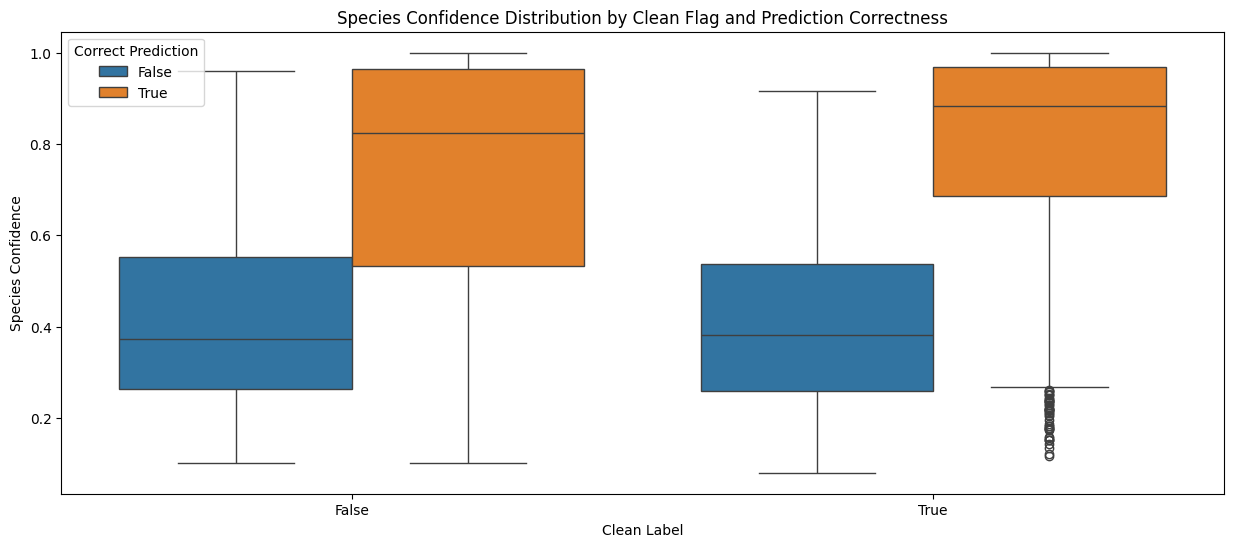

In [73]:
# Boxplot: Confidence Distribution for Correct and Incorrect Predictions, split by Clean Flag
plt.figure(figsize=(15, 6))
sns.boxplot(x='clean', y='species_conf', hue='correct', data=test_df)
plt.title('Species Confidence Distribution by Clean Flag and Prediction Correctness')
plt.xlabel('Clean Label')
plt.ylabel('Species Confidence')
plt.legend(title='Correct Prediction', loc='upper left')
plt.show()

In [23]:
import pandas as pd
from sklearn.metrics import precision_score

# Assuming your DataFrame 'df' has the following columns:
# 'species': true labels
# 'species_pred': predicted labels
# 'clean': boolean flag (True for clean, False for non-clean)

# Calculate precision for non-clean samples (macro-average, change as needed)
precision_non_clean = precision_score(
    test_df[test_df['clean'] == False]['species'],
    test_df[test_df['clean'] == False]['species_pred'],
    average='macro'
)

# Calculate precision for clean samples
precision_clean = precision_score(
    test_df[test_df['clean'] == True]['species'],
    test_df[test_df['clean'] == True]['species_pred'],
    average='macro'
)

# Compute the gain in precision
absolute_gain_precision = precision_clean - precision_non_clean
relative_gain_precision = (absolute_gain_precision / precision_non_clean) * 100

print(f"Precision on non-clean data: {precision_non_clean:.3f}")
print(f"Precision on clean data: {precision_clean:.3f}")
print(f"Absolute gain in precision: {absolute_gain_precision:.3f} (or {absolute_gain_precision*100:.2f} percentage points)")
print(f"Relative gain in precision: {relative_gain_precision:.2f}%")


Precision on non-clean data: 0.344
Precision on clean data: 0.631
Absolute gain in precision: 0.286 (or 28.64 percentage points)
Relative gain in precision: 83.24%


In [74]:
import pandas as pd
from sklearn.metrics import accuracy_score


# Calculate accuracy for clean and non-clean samples
df_clean = test_df[test_df['clean'] == True]
df_non_clean = test_df[test_df['clean'] == False]

accuracy_clean = accuracy_score(df_clean['species'], df_clean['species_pred'])
accuracy_non_clean = accuracy_score(df_non_clean['species'], df_non_clean['species_pred'])

# Calculate absolute gain in accuracy (difference between clean and non-clean)
absolute_gain_accuracy = accuracy_clean - accuracy_non_clean

# Calculate relative gain in accuracy (how much percent we gain compared to non-clean)
relative_gain_accuracy = (absolute_gain_accuracy / accuracy_non_clean) * 100

print(f"Accuracy on non-clean data: {accuracy_non_clean:.4f}")
print(f"Accuracy on clean data: {accuracy_clean:.4f}")
print(f"Absolute gain in accuracy: {absolute_gain_accuracy:.4f} (or {absolute_gain_accuracy*100:.2f} percentage points)")
print(f"Relative gain in accuracy: {relative_gain_accuracy:.2f}%")


Accuracy on non-clean data: 0.7495
Accuracy on clean data: 0.8615
Absolute gain in accuracy: 0.1120 (or 11.20 percentage points)
Relative gain in accuracy: 14.94%


<Axes: xlabel='correct', ylabel='species_conf'>

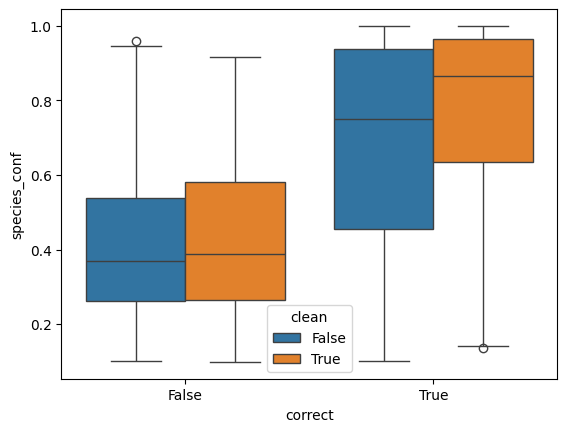

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

df_graph = test_df[test_df['source'] == 'inat']

sns.boxplot(x='correct', y='species_conf', data=df_graph,hue='clean')


In [78]:
import plotly.express as px

fig = px.box(df_graph, x="correct", y="species_conf", color="clean", title="Box plot of species confidence by correctness")
fig.show()

<Axes: xlabel='species', ylabel='species_conf'>

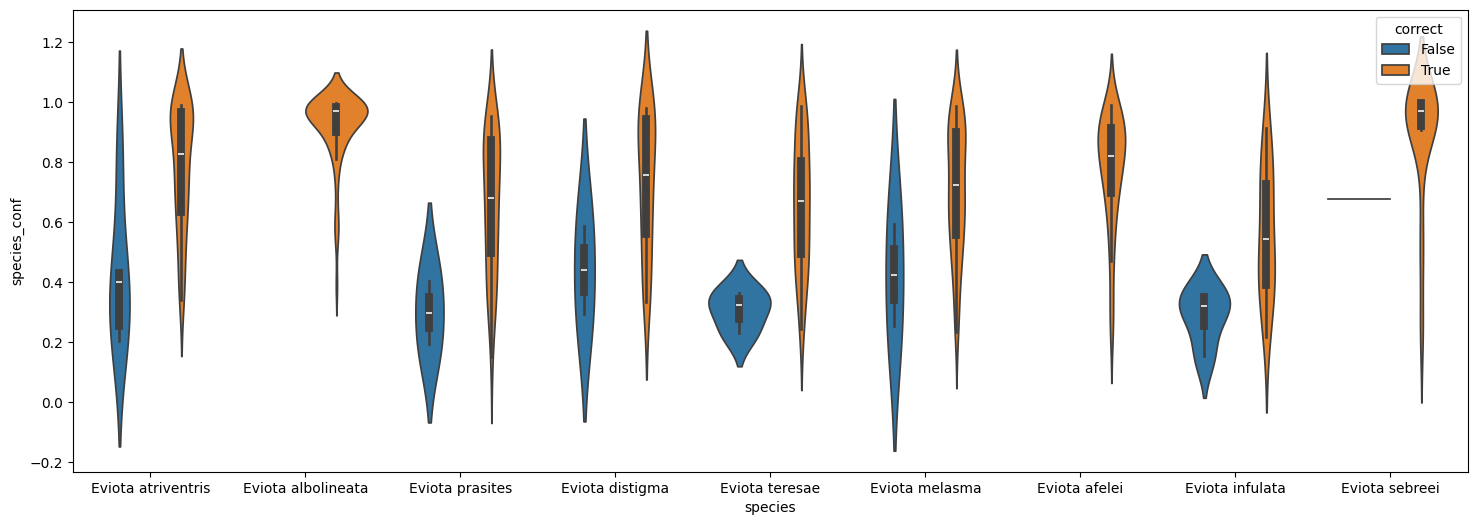

In [79]:
df_eviota = test_df[test_df['genus'] == 'Eviota']

plt.figure(figsize=(18, 6))
sns.violinplot(x='species', y='species_conf', data=df_eviota, hue='correct')

In [39]:
from sklearn.metrics import classification_report

report = classification_report(test_df['species'], test_df['species_pred'], target_names=labels['species'], output_dict=True)

rpt = pd.DataFrame(report).transpose()

rpt = rpt.reset_index().rename(columns={'index':'species'})

rpt.head(10)

species  precision    recall  f1-score  support
0   Acanthemblemaria aspera   0.835294  0.910256  0.871166     78.0
1  Acanthemblemaria spinosa   0.681818  0.909091  0.779221     33.0
2      Amblygobius phalaena   0.857143  0.692308  0.765957     26.0
3          Apogon binotatus   1.000000  0.785714  0.880000     28.0
4          Apogon maculatus   0.833333  0.909091  0.869565     44.0
5     Canthigaster solandri   0.925234  0.908257  0.916667    109.0
6     Caracanthus maculatus   0.896552  0.896552  0.896552     29.0
7      Caracanthus unipinna   0.941176  0.842105  0.888889     19.0
8      Centropyge bispinosa   0.796610  0.903846  0.846847     52.0
9     Centropyge flavissima   0.813953  0.853659  0.833333     41.0

In [148]:
def species_short(species):
    genus, species = species.split(' ')
    return f'{genus[0]} {species}'

test_df['species_short'] = test_df['species'].apply(species_short)

test_df.head()

image_path  \
0  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
1  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   
2  /Volumes/T7_shield/CryptoVision/Data/Sources/W...   
3  /Volumes/T7_shield/CryptoVision/Data/Sources/L...   
4  /Volumes/T7_shield/CryptoVision/Data/Sources/I...   

                        folder_label         family          genus  \
0      Gobiidae_Fusigobius_neophytus       Gobiidae     Fusigobius   
1   Pomacentridae_Pomacentrus_adelus  Pomacentridae    Pomacentrus   
2  Cirrhitidae_Paracirrhites_arcatus    Cirrhitidae  Paracirrhites   
3     Gobiidae_Paragobiodon_modestus       Gobiidae   Paragobiodon   
4  Syngnathidae_Doryrhamphus_excisus   Syngnathidae   Doryrhamphus   

                 species source              hash  width  height  \
0   Fusigobius neophytus   inat  c183f04187bc9bfc   1505    1129   
1     Pomacentrus adelus   inat  bae6cd383245ae4a   1350    1352   
2  Paracirrhites arcatus    web  d53b6a0a3527d8b4    370     276   
3  Paragobiodon modestus    sjb  c11e9e63e01e0ff1   4288    2848   
4   Doryrhamphus excisus   inat  a5a2d16d9d4d3c4c   1068     602   

   aspect_ratio  ...            species_pred species_conf  correct  \
0          1.33  ...        Ecsenius stictus     0.266846    False   
1          1.00  ...      Pomacentrus adelus     0.592773     True   
2          1.34  ...   Paracirrhites arcatus     0.786133     True   
3          1.51  ...   Paragobiodon modestus     0.945312     True   
4          1.77  ...  Pristiapogon exostigma     0.516602    False   

   sp_correct  precision    recall  f1-score support  fam_correct  \
0       False   0.653846  0.680000  0.666667    50.0         True   
1        True   0.781250  0.609756  0.684932    41.0         True   
2        True   0.809524  0.944444  0.871795    54.0        False   
3        True   0.967742  0.937500  0.952381    32.0         True   
4       False   0.811321  0.895833  0.851485    48.0        False   

  species_short  
0   F neophytus  
1      P adelus  
2     P arcatus  
3    P modestus  
4     D excisus  

[5 rows x 33 columns]

In [128]:
test_df = test_df.merge(rpt, on='species', how='left')

In [ ]:
test_df.head(10)

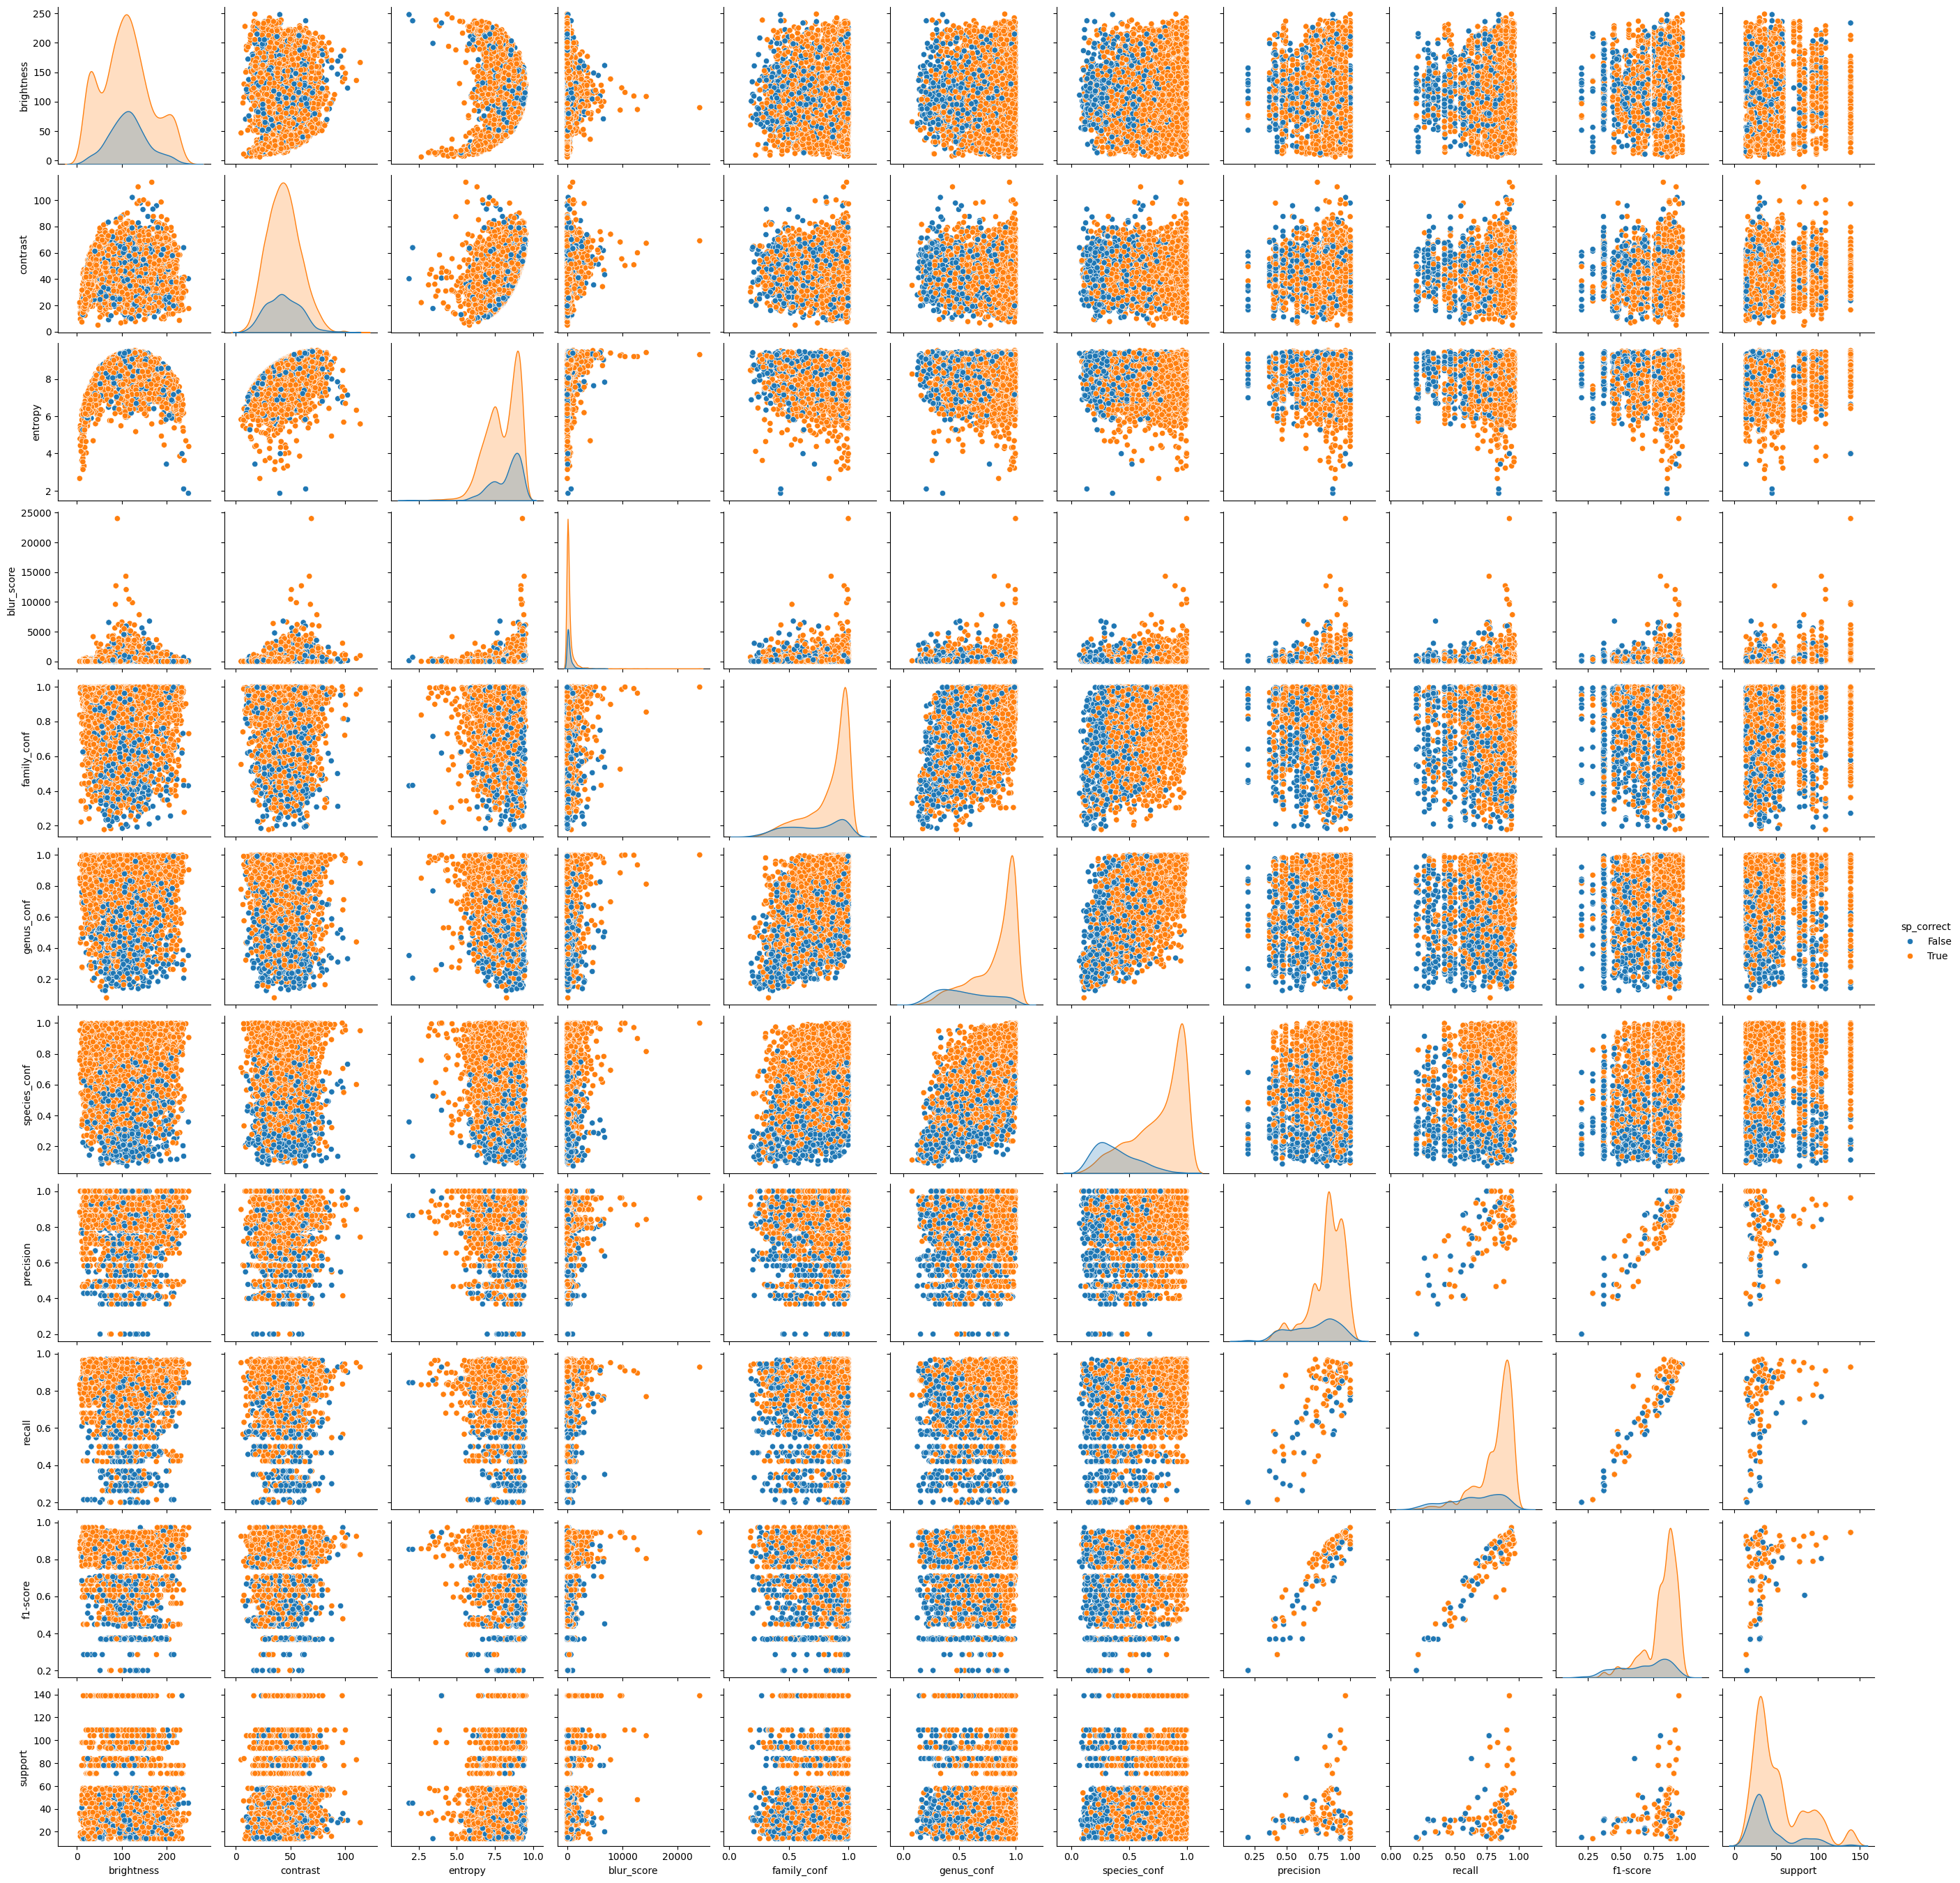

In [152]:
df_plot = test_df[['brightness', 'contrast', 'entropy', 'blur_score', 'family_conf','genus_conf', 'species_conf', 'precision','recall','f1-score','support','sp_correct']]

sns.pairplot(df_plot, hue='sp_correct')

In [118]:
def weighted_taxonomic_score(row, w_family=0.2, w_genus=0.3, w_species=0.5):
    score = 0.0
    if row['family'] == row['family_pred']:
        score += w_family
    if row['genus'] == row['genus_pred']:
        score += w_genus
    if row['species'] == row['species_pred']:
        score += w_species
    return score

def taxonomic_distance(row):
    # If family is incorrect, we give the worst penalty.
    if row['family'] != row['family_pred']:
        return 3
    # If family is correct but genus is wrong.
    elif row['genus'] != row['genus_pred']:
        return 2
    # If family and genus are correct but species is wrong.
    elif row['species'] != row['species_pred']:
        return 1
    else:
        return 0

df_pred = test_df[['family', 'family_pred', 'genus', 'genus_pred', 'species', 'species_pred']]

df_pred['weighted_score'] = df_pred.apply(weighted_taxonomic_score, axis=1)
df_pred['taxonomic_distance'] = df_pred.apply(taxonomic_distance, axis=1)

df_pred.head(10)

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_70595/4070285584.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_70595/4070285584.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



family    family_pred          genus     genus_pred  \
0       Gobiidae       Gobiidae     Fusigobius   Ctenogobiops   
1  Pomacentridae  Pomacentridae    Pomacentrus    Pomacentrus   
2    Cirrhitidae     Blenniidae  Paracirrhites  Paracirrhites   
3       Gobiidae       Gobiidae   Paragobiodon   Paragobiodon   
4   Syngnathidae       Labridae   Doryrhamphus   Pristiapogon   
5     Blenniidae       Gobiidae   Plagiotremus   Plagiotremus   
6  Pomacentridae  Pomacentridae        Chromis    Pomacentrus   
7       Labridae       Labridae     Thalassoma     Thalassoma   
8     Apogonidae     Apogonidae   Pristiapogon   Pristiapogon   
9       Gobiidae       Gobiidae         Eviota         Eviota   

                      species                species_pred  weighted_score  \
0        Fusigobius neophytus            Ecsenius stictus             0.2   
1          Pomacentrus adelus          Pomacentrus adelus             1.0   
2       Paracirrhites arcatus       Paracirrhites arcatus             0.8   
3       Paragobiodon modestus       Paragobiodon modestus             1.0   
4        Doryrhamphus excisus      Pristiapogon exostigma             0.0   
5  Plagiotremus rhinorhynchus  Plagiotremus rhinorhynchus             0.8   
6        Chromis margaritifer     Neopomacentrus cyanomos             0.2   
7    Thalassoma amblycephalum    Thalassoma amblycephalum             1.0   
8      Pristiapogon exostigma      Pristiapogon exostigma             1.0   
9          Eviota atriventris          Eviota atriventris             1.0   

   taxonomic_distance  
0                   2  
1                   0  
2                   3  
3                   0  
4                   3  
5                   3  
6                   2  
7                   0  
8                   0  
9                   0

In [121]:
df_pred['correct'] = df_pred['genus'] == df_pred['genus_pred']

df_pred[df_pred['correct'] == True]['taxonomic_distance'].value_counts()

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_70595/2920740645.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



taxonomic_distance
0    2964
1     351
3     208
Name: count, dtype: int64